In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import pytz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
from sklearn.preprocessing import scale


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

## Preparación de datos

### Datos con IDA

In [83]:
df_esios = pd.read_csv('data_training/esios_previsiones_d+1.csv')
df_esios['Date'] = pd.to_datetime(df_esios['Date']).dt.date

# Datetime de inicio del periodo
df_esios['Datetime'] = pd.to_datetime(df_esios['Date']) + pd.to_timedelta(df_esios['Hour'] - 1, unit='h')

df_esios

,indicator_id,Date,Hour,geo_id,value,Datetime
0,1775,2022-01-01,1,8741,21705.00,2022-01-01 00:00:00
1,1775,2022-01-01,2,8741,21373.00,2022-01-01 01:00:00
2,1775,2022-01-01,3,8741,20088.00,2022-01-01 02:00:00
3,1775,2022-01-01,4,8741,19261.00,2022-01-01 03:00:00
4,1775,2022-01-01,5,8741,18717.00,2022-01-01 04:00:00
...,...,...,...,...,...,...
183143,600,2025-06-30,20,3,111.38,2025-06-30 19:00:00
183144,600,2025-06-30,21,3,135.00,2025-06-30 20:00:00
183145,600,2025-06-30,22,3,175.01,2025-06-30 21:00:00
183146,600,2025-06-30,23,3,157.00,2025-06-30 22:00:00


In [84]:
df_esios_clean = df_esios[['Datetime', 'indicator_id', 'value']].copy()
df_esios_clean.drop_duplicates(subset=['Datetime', 'indicator_id'], keep='first', inplace=True)

df_esios_pivot = df_esios_clean.pivot(
    index='Datetime',
    columns='indicator_id',
    values='value'
).reset_index()

df_esios_pivot

indicator_id,Datetime,600,612,613,1775,1777,1779
0,2022-01-01 00:00:00,145.86,138.36,131.27,21705.0,6365.0,0.0
1,2022-01-01 01:00:00,114.90,114.90,114.90,21373.0,6376.0,0.0
2,2022-01-01 02:00:00,113.87,113.87,113.87,20088.0,6356.0,0.0
3,2022-01-01 03:00:00,97.80,95.31,97.81,19261.0,6351.0,0.0
4,2022-01-01 04:00:00,97.80,92.80,91.40,18717.0,6268.0,0.0
...,...,...,...,...,...,...,...
30643,2025-06-30 19:00:00,111.38,NaN,NaN,NaN,NaN,NaN
30644,2025-06-30 20:00:00,135.00,NaN,NaN,NaN,NaN,NaN
30645,2025-06-30 21:00:00,175.01,NaN,NaN,NaN,NaN,NaN
30646,2025-06-30 22:00:00,157.00,NaN,NaN,NaN,NaN,NaN


Limpieza de datos

In [57]:
df_input = df_esios_pivot.copy()

df_input['Year'] = df_input['Datetime'].dt.year
df_input['Month'] = df_input['Datetime'].dt.month
df_input['Day_of_Week'] = df_input['Datetime'].dt.dayofweek
df_input['Hour'] = df_input['Datetime'].dt.hour

dicc_indicators = {1775: 'demanda', 1777: 'gen_eolica', 1779: 'gen_fotovoltaica', 600: 'MD', 612: 'IDA1', 613: 'IDA2'}

df_input.rename(columns=dicc_indicators, inplace=True)


# No conocemos el valor del IDA en el día D así que usamos el de D-1
df_input['IDA1_lag_24'] = df_input['IDA1'].shift(24)
df_input['IDA2_lag_24'] = df_input['IDA2'].shift(24)
df_input.drop(columns=['IDA1', 'IDA2'], inplace=True)

Feature Engineering

In [58]:
# Nuevos predictores - Valor del MD en el D-1, D-2 y D-7
df_input['MD_lag_24'] = df_input['MD'].shift(24)
df_input['MD_lag_48'] = df_input['MD'].shift(48)
df_input['MD_lag_1w'] = df_input['MD'].shift(24*7)

# Nuevo predictor - Variable binaria a partir de la generacion solar
df_input['hora_solar'] = np.where(
    df_input['gen_fotovoltaica'] == 0,
    0,
    1
)


# Promedio de los tres mercados D-1
df_input['mean_market_lag_24'] = df_input[['MD_lag_24', 'IDA1_lag_24', 'IDA2_lag_24']].mean(axis=1)
df_input = df_input.drop(columns=['Datetime'])
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30648 entries, 0 to 30647
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MD                  30644 non-null  float64
 1   demanda             30598 non-null  float64
 2   gen_eolica          30598 non-null  float64
 3   gen_fotovoltaica    30598 non-null  float64
 4   Year                30648 non-null  int32  
 5   Month               30648 non-null  int32  
 6   Day_of_Week         30648 non-null  int32  
 7   Hour                30648 non-null  int32  
 8   IDA1_lag_24         30285 non-null  float64
 9   IDA2_lag_24         30405 non-null  float64
 10  MD_lag_24           30620 non-null  float64
 11  MD_lag_48           30596 non-null  float64
 12  MD_lag_1w           30476 non-null  float64
 13  hora_solar          30648 non-null  int32  
 14  mean_market_lag_24  30624 non-null  float64
dtypes: float64(10), int32(5)
memory usage: 2.9 MB


Limpieza de nulos

In [59]:
df_input = df_input.dropna(axis=0)
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29907 entries, 168 to 30624
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MD                  29907 non-null  float64
 1   demanda             29907 non-null  float64
 2   gen_eolica          29907 non-null  float64
 3   gen_fotovoltaica    29907 non-null  float64
 4   Year                29907 non-null  int32  
 5   Month               29907 non-null  int32  
 6   Day_of_Week         29907 non-null  int32  
 7   Hour                29907 non-null  int32  
 8   IDA1_lag_24         29907 non-null  float64
 9   IDA2_lag_24         29907 non-null  float64
 10  MD_lag_24           29907 non-null  float64
 11  MD_lag_48           29907 non-null  float64
 12  MD_lag_1w           29907 non-null  float64
 13  hora_solar          29907 non-null  int32  
 14  mean_market_lag_24  29907 non-null  float64
dtypes: float64(10), int32(5)
memory usage: 3.1 MB


### Datos con OMIP

In [99]:
df_esios_omip = pd.read_csv('data_training/predictores_modelo_futuro.csv')
df_esios_omip['Datetime_hour'] = pd.to_datetime(df_esios_omip['Datetime_hour'])

# fecha_inicio = '2025-01-01'
# df_esios_omip = df_esios_omip[df_esios_omip['Datetime_hour'] >= fecha_inicio]

utc_zone = pytz.timezone('UTC')
spain_zone = pytz.timezone('Europe/Madrid')
df_esios_omip['Datetime_hour_spain'] = df_esios_omip['Datetime_hour'].dt.tz_localize(utc_zone).dt.tz_convert(spain_zone)

df_esios_omip['Year'] = df_esios_omip['Datetime_hour_spain'].dt.year
df_esios_omip['Month'] = df_esios_omip['Datetime_hour_spain'].dt.month
df_esios_omip['Day_of_Week'] = df_esios_omip['Datetime_hour_spain'].dt.dayofweek
df_esios_omip['Hour'] = df_esios_omip['Datetime_hour_spain'].dt.hour

df_esios_omip.drop(['Datetime_hour_spain'], axis=1, inplace=True)

df_esios_omip

,Datetime_hour,MD,Demanda,Gen.Eolica,Gen.Fotovoltaica,MD_lag_24,FTB,FTS,Year,Month,Day_of_Week,Hour
0,2024-01-01 23:00:00,37.80,21500.0,9540.3,0.0,63.33,52.46,47.42,2024,1,1,0
1,2024-01-02 00:00:00,25.00,19808.8,9407.5,0.0,50.09,52.46,47.42,2024,1,1,1
2,2024-01-02 01:00:00,3.99,18687.5,9231.5,0.0,47.50,52.46,47.42,2024,1,1,2
3,2024-01-02 02:00:00,14.00,18186.3,9116.5,0.0,43.50,52.46,47.42,2024,1,1,3
4,2024-01-02 03:00:00,10.00,18070.5,9107.5,0.0,42.50,52.46,47.42,2024,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
13795,2025-07-31 18:00:00,107.99,32459.3,9680.5,3899.3,77.99,35.73,8.97,2025,7,3,20
13796,2025-07-31 19:00:00,114.45,32319.0,11117.5,336.3,101.49,35.73,8.97,2025,7,3,21
13797,2025-07-31 20:00:00,110.27,31198.8,10593.8,0.0,104.36,35.73,8.97,2025,7,3,22
13798,2025-07-31 21:00:00,98.32,28856.5,10664.5,0.0,92.18,35.73,8.97,2025,7,3,23


In [100]:
df_input = df_esios_omip.drop(columns=['Datetime_hour'])

# Modelo Dense Neural Network

PARAMETROS

In [101]:
porc_train = 0.5
porc_val = 0.25

n_neurons_1 = 128
n_neurons_2 = 128
dropout = 0.3

lr = 0.0005
patience = 15
batch_size = 64

### Split train - test

In [102]:
num_train_samples = int(porc_train*len(df_input))
num_val_samples = int(porc_val*len(df_input))

X_train = df_input.drop('MD', axis=1).iloc[:num_train_samples]
X_val = df_input.drop('MD', axis=1).iloc[num_train_samples:num_train_samples+num_val_samples]
X_test = df_input.drop('MD', axis=1).iloc[num_train_samples+num_val_samples:]

y_train = df_input['MD'].iloc[:num_train_samples]
y_val = df_input['MD'].iloc[num_train_samples:num_train_samples+num_val_samples]
y_test = df_input['MD'].iloc[num_train_samples+num_val_samples:]

Normalizacion

In [103]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Para la variable objetivo
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

### Modelo Deep Learning

In [104]:
# Obtener el número de características
n_features = X_train.shape[1]

# Construir el modelo
model = keras.Sequential([
    layers.Dense(n_neurons_1, activation='relu', kernel_regularizer=regularizers.l2(1e-4), input_shape=(n_features,)),
    layers.BatchNormalization(),
    layers.Dropout(dropout),
    layers.Dense(n_neurons_2, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(dropout),
    layers.Dense(1)  # Capa de salida para regresión
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss='mse',
    metrics=['mae']  # MAE como métrica principal
)

c:\Users\jnavarro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_mae',  # Monitorear MAE de validation
        patience=patience,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'modelo_futuro.keras',
        monitor='val_mae',
        save_best_only=True,
        verbose=1
    )
]
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),  # Usar validation set
    epochs=150,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
102/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8657 - mae: 1.0596 
Epoch 1: val_mae improved from None to 0.96575, saving model to modelo_futuro.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4336 - mae: 0.9282 - val_loss: 1.2454 - val_mae: 0.9657
Epoch 2/150
 80/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9733 - mae: 0.7701
Epoch 2: val_mae improved from 0.96575 to 0.87013, saving model to modelo_futuro.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8707 - mae: 0.7257 - val_loss: 1.0407 - val_mae: 0.8701
Epoch 3/150
 99/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6478 - mae: 0.6352
Epoch 3: val_mae improved from 0.87013 to 0.65235, saving model to modelo_futuro.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6044 - mae: 0.6102 - val_loss: 0.6051 - val_mae: 0.6523
Epoch 4/150
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4859 - mae: 0.5460
Epoch 4: val_mae improved from 0.65235 to 0.56502, saving model to modelo_futuro.keras
108/1

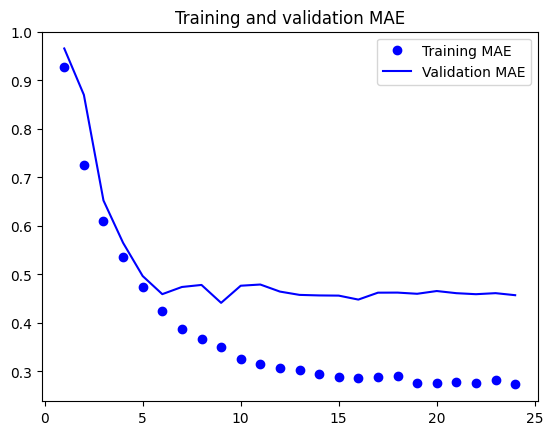

In [106]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


EVALUACIÓN FINAL CON TEST SET
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


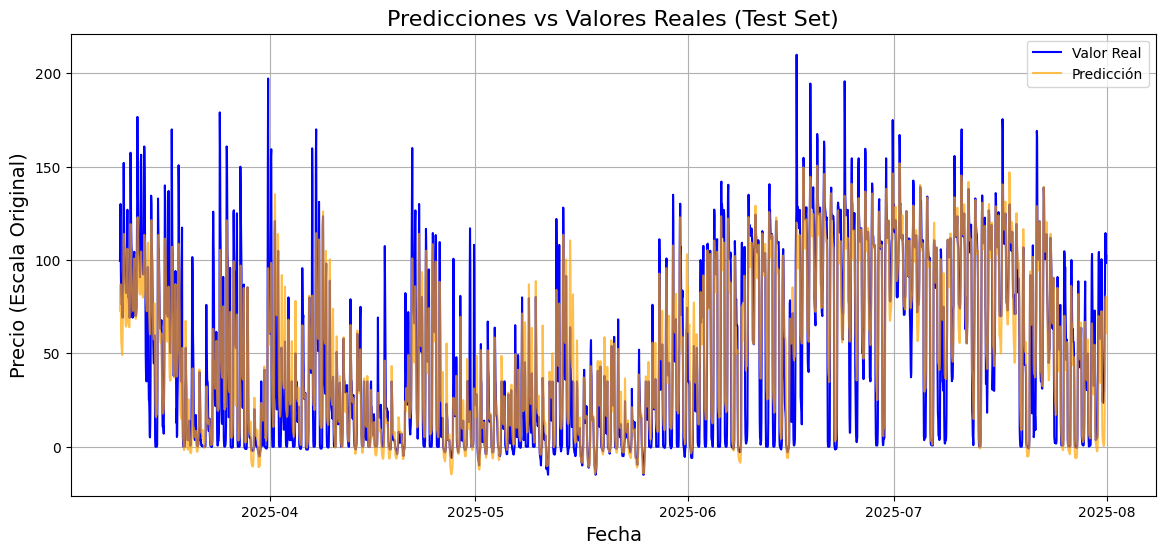

In [107]:
# Evaluar el modelo con el test set (datos nunca vistos)
print("\n" + "="*50)
print("EVALUACIÓN FINAL CON TEST SET")
print("="*50)

# Hacer predicciones en el test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

fechas_test = df_esios_omip['Datetime_hour'].iloc[num_train_samples+num_val_samples:]

plt.figure(figsize=(14,6))
plt.plot(fechas_test, y_real, label='Valor Real', color='blue')
plt.plot(fechas_test, y_pred, label='Predicción', color='orange', alpha=0.7)
plt.title('Predicciones vs Valores Reales (Test Set)', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio (Escala Original)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [96]:
y_real

array([  1.72,   1.72,   2.95, ..., 110.27,  98.32, 102.22])